# Assignment 2:  Implicit Neural Representation

Name: Yi-Chung Chen

UID:  119218990

Link to Google Drive : **View-only Link to Notebook Here (make sure it works)**

Please submit a PDF containing all outputs to gradescope by **October 31, 11:59pm**

----------------------------

In this assignment, you will get some hands-on experience with implicit neural representation (INR). With INR, we parameterize some signal (in our case images) with a neural network (in this assignment, we will use a basic feed-forward network). While in practice this might be useful for outpainting, super-resolution, and compression, in this assignment we will mainly focus on the basics, with some proof-of-concept outpainting at the end. Your outputs might not look great, this is okay as long as they are at least as good as the examples.

## Dataset

As always, we start with the data. In this section, you will need to complete the following steps:

1. Choose an image. If you're working in colab, you will need to either mount your Google Drive, or else upload the file directly.
2. Write SingleImageDataset. This is how you'll convert your image into model inputs and targets. You will instantiate the dataset and a dataloader to check and make sure you did this part correctly.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'Maryland/UMD/Robotics/Courses/2023 Fall/CMSC828I/Assignment 2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


### Question 1: Selecting an image (5 points)

Free points! Just show your image here. One catch- make sure the image is less than 62500 pixels, total. We do not want you to waste time waiting for your model to train.

(150, 150, 3)


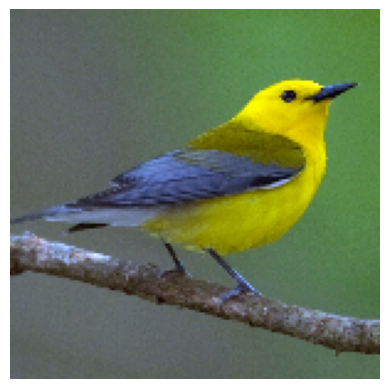

True

In [7]:
from torchvision.io import read_image  ## Note: feel free to use another loader
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

img_path = r'../data/'

image = cv2.imread(img_path + 'bird.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

height, width, _ = image.shape
re_size = 150


image = cv2.resize(image, (int(re_size), int(re_size)), interpolation= cv2.INTER_LINEAR)
print(image.shape)
plt.imshow(image)#.permute(1, 2, 0).numpy()
plt.axis('off')
plt.show()
plt.close()

# Save the resize image
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
os.chdir(img_path)
cv2.imwrite("image.png", image)

### Question 2: Writing the dataset (20 points)

For this part, you need to fill in the blanks for the dataset provided below. Alternatively, feel free to write it from scratch, the scaffolding was provided to help you, not to trap you in a box.

You will also need to write a loop to construct the image, using a dataloader for your SingleImageDataset. We provide more details in comments below.

We will be grading your code and your image outputs. In Gradescope, make sure both are fully visible.

In [2]:
from torchvision.io import read_image
from torch.utils.data import Dataset

class SingleImageDataset(Dataset):
    def __init__(self, img_path):
        self.image = read_image(img_path)
        self.num_channels, self.h, self.w = self.image.shape

    def __len__(self):
        ### TODO: 1 line of code for returning the number of pixels
        return self.h * self.w

    def __getitem__(self, idx):
        ### TODO: 2-3 lines of code for x, y, and pixel values
        x = (idx // self.w) % self.h
        y = idx % self.w
        intensity = np.asarray(self.image)[:, y, x]/255

        return {"x": x, "y": y, "intensity": intensity}

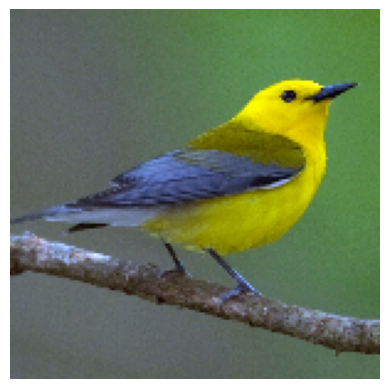

In [8]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataset = SingleImageDataset(img_path + 'image.png')

batch_size = 1
### TODO: 1 line of code for initializing a DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

### TODO: 6-10 lines of code for using your dataloader to retrieve, reassemble,
###       and display your image
reasmb_img = np.zeros((image.shape))

for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    reasmb_img[y.item(), x.item()] = np.asarray(intensity)[0]*255

plt.imshow(reasmb_img.astype(np.uint8))
plt.axis('off')
plt.show()

## Network


### Question 3: Defining the Network (15 points)

Define a feedforward neural network.
Remember that the last layer output dimension should be equal to the number of color channels.

A very basic network might have a linear layer, followed by a ReLU, followed by another linear layer.

In [9]:
import torch.nn as nn

class FFN(torch.nn.Module):
    def __init__(self):
        super(FFN, self).__init__()
        ### TODO: define and initialize some layers with weights
        self.layers = nn.Sequential(
            nn.Linear(2, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 3),
        )

    def forward(self, coord):
        out = self.layers(coord)
        return out


## Training

Now that you have a dataset and model, time to put it together!

Instantiate an optimizer and a criterion.
Loop over your dataset until the network converges.
Track your loss. We will be asking you to plot it later.

In [10]:
from numpy.ma.core import size
from tqdm import tqdm

device = ("cuda"
      if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu")

print(f"Using {device} device")

net = FFN().to(device)

lr = 1e-4
b_size = 128

dataloader = DataLoader(dataset, batch_size=b_size, shuffle=False)

# since we are training the network for pixels,
# we will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

### TODO: 2 lines of code for optimizer, number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
NUM_EPOCHS = 1000

loss_values = []
### TODO: set up mechanism for storing loss values
for epoch in range(NUM_EPOCHS):
  for batch in dataloader:
      x, y, actual = batch["x"], batch["y"], batch["intensity"]
      x = x / dataset.w # normalizing x between 0 and 1
      y = y / dataset.h # normalizing y between 0 and 1

      ### TODO: 3 lines of code to assemble coord from x and y, pass to net,
      ###       compute loss
      coord = torch.stack((x, y), dim=-1).to(device)
      pred = net(coord)
      loss = criterion(pred, actual.float().to(device))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  ### TODO: track loss
  loss_values.append(loss.item())
  avg_loss = sum(loss_values) / len(loss_values)
  print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_loss}")

# torch.save(net.state_dict(), img_path+'save_model.pt')

Using cuda device
Epoch [1/1000], Loss: 0.004154927097260952
Epoch [2/1000], Loss: 0.0042106821201741695
Epoch [3/1000], Loss: 0.0042237321225305395
Epoch [4/1000], Loss: 0.004250232595950365
Epoch [5/1000], Loss: 0.004276338964700699
Epoch [6/1000], Loss: 0.004283443403740724
Epoch [7/1000], Loss: 0.0042869398769523415
Epoch [8/1000], Loss: 0.004287916235625744
Epoch [9/1000], Loss: 0.0043084182155629
Epoch [10/1000], Loss: 0.004312551533803344
Epoch [11/1000], Loss: 0.004319250541315837
Epoch [12/1000], Loss: 0.004312273658191164
Epoch [13/1000], Loss: 0.004301916915350235
Epoch [14/1000], Loss: 0.004294625516714794
Epoch [15/1000], Loss: 0.0042911956707636515
Epoch [16/1000], Loss: 0.004287034826120362
Epoch [17/1000], Loss: 0.004287653136998415
Epoch [18/1000], Loss: 0.004294374414409201
Epoch [19/1000], Loss: 0.0043083963866688705
Epoch [20/1000], Loss: 0.0043261953396722674
Epoch [21/1000], Loss: 0.004332857539079019
Epoch [22/1000], Loss: 0.0043390749276361685
Epoch [23/1000], L

### Question 4: Plot loss over time (20 points)

For this part, plot your loss from training the model.

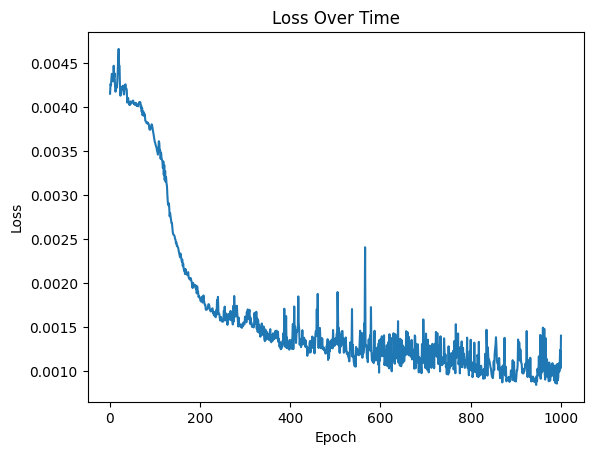

In [11]:
### TODO: make plot of reconstruction loss (y-axis) over training time (x-axis)
plt.plot(range(1, NUM_EPOCHS + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()

## Evaluation

In [12]:
# Load model
model_path = img_path + 'save_model.pt'
net.load_state_dict(torch.load(model_path))
net.eval()

FFN(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

### Question 5: Reconstruct whole image (20 points)

For this part, reconstruct the image using your model's outputs, at each coordinate.
You can use our scaffolding code, or write your own.
For this part, we are just grading the image plot, where you should plot the original image side-by-side with the reconstruction, as shown in this example.

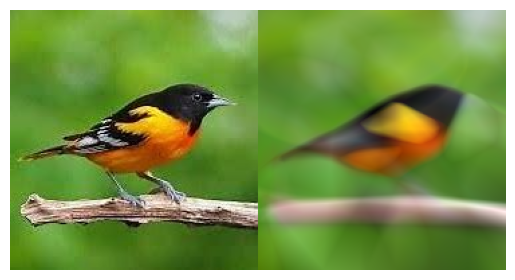

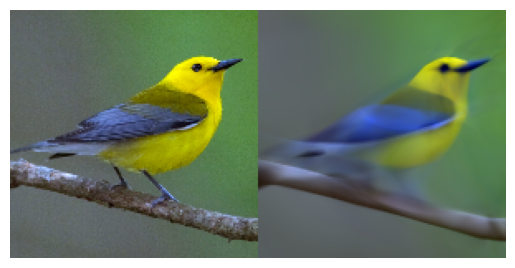

In [13]:
### TODO: ~12 lines of code to assemble gt_image, build pred_image
###       from model

img = read_image(img_path+'image.png')

gt_image = torch.zeros(img.shape)
pred_image = torch.zeros(img.shape)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    gt_image[:, y.item(), x.item()] = intensity*255

    x_ = x / dataset.w # normalizing x between 0 and 1
    y_ = y / dataset.h # normalizing y between 0 and 1

    coord = torch.stack((x_, y_), dim=-1)
    pred = net(coord.to(device))

    pred_image[:, y.item(), x.item()] = pred*255

pred_image = torch.clip(pred_image, 0, 255)

joint_image = torch.cat([gt_image.type(torch.uint8), pred_image.type(torch.uint8)], dim=2)
plt.imshow(joint_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
plt.close()

### Question 6: Compute PSNR (10 points)

For this part, print the PSNR for your reconstruction vs. the original image. Feel free to use any libraries, or implement it from scratch.

In [14]:
### TODO: compute and print PSNR between reconstructed (predicted) and ground truth images
# import torch.nn.functional as F


if gt_image.shape != pred_image.shape:
    raise ValueError("Both images must have the same dimensions.")

mse = nn.functional.mse_loss(gt_image, pred_image)

max_value = torch.tensor(255, dtype=torch.uint8)

psnr = 20 * torch.log10(max_value) - 10 * torch.log10(mse)

print(f'PSNR: {psnr.item()} dB')

PSNR: 21.92862892150879 dB


### Question 7: Outpainting (10 points)

INR is a continuous image representation. What happens if your input coordinates don't correspond to real pixels? Try it out and show the result!

For this part, have your model predict 20 pixels in all directions that are outside the boundaries of the original image, and show the resulting image below. Also plot a box around the region corresponding to the original image, for clarity.

We show an example below.

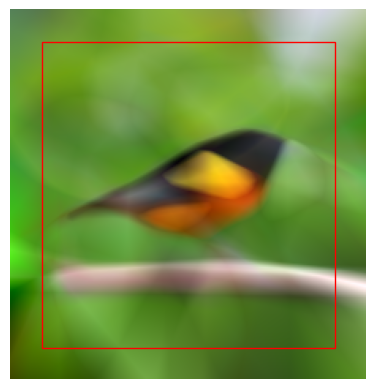

In [ ]:
import matplotlib.patches as patches

### TODO: 6-10 lines of code to generate outpainted image
channels, height, width = pred_image.shape

# initialize the outpainted image
outpainted_image = torch.zeros(channels, height + 2*20, width + 2*20)

for x in range(outpainted_image.shape[2]):
  for y in range(outpainted_image.shape[1]):

    x_ = torch.tensor((x - 20) / dataset.w)
    y_ = torch.tensor((y - 20) / dataset.h)

    coord = torch.stack((x_, y_), dim=-1)

    pred = net(coord.to(device))

    outpainted_image[:, y, x] = 255*pred

outpainted_image = torch.clip(outpainted_image, 0, 255).type(torch.uint8)

fig, ax = plt.subplots()
ax.imshow(outpainted_image.permute(1, 2, 0))
rect = patches.Rectangle((20, 20), dataset.w, dataset.h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis('off')
plt.show()
plt.close()

## Bonus

The main idea of the bonus is to do something to make your model better than the one we walk you through in the assignment. Be creative! You can receive a maximum of 20 points for this portion.

### Question 8: Improve the Reconstruction Quality of the System (20 points, optional)

For this question, you must do two things:

1. Make a non-trivial change from what we guided you through in the assignment.
2. Prove that the change improves reconstruction quality. Compare your new output/PSNR to the old output/PSNR (plot the images, print the PSNR).

If you can't think of your own idea, revisit some of the literature from Shishira's guest lectures. For example, instead of taking raw coordinate inputs, you could try using positional encodings.

In [ ]:
### TODO: bonus